In [1]:
import os
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.reduce import __reduce
from functions.smoothing import __smooth
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.load_beam_wander_data import __load_beam_wander_data

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

### Load Configuration

In [4]:
config = {}

# config['camera'] = "01"

config['path_to_data'] = data_path+f"ids/"

config['path_to_outdata'] = data_path+f"ids/"

config['path_to_figures'] = data_path+"ids/figures/"

config['path_to_autodata'] = archive_path+f"romy_autodata/"

# conversion from pixel to mm
config['conversion'] = {"XX":1.67e-3,
                        "01":5.3e-3,
                        "03":5.3e-3,
                        "05":5.3e-3,
                        "07":5.3e-3,
                       }

# experiment 2 (after setup monobeams at RZ (S))
# config['date1'] = "2024-08-03"
# config['date2'] = "2024-08-09"

# experiment 3 (after setup monobeams at RZ (S))
# config['date1'] = "2024-08-09"
# config['date2'] = "2024-08-20"

# experiment with FSR
config['date1'] = "2024-08-22"
config['date2'] = str(UTCDateTime.now().date)


config['t1'] = UTCDateTime(config['date1']) + 12*3600
config['t2'] = UTCDateTime(config['date2']) + 86400


### Load MLTI

In [5]:
mlti = __load_mlti(config['date1'], config['date2'], "Z", archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

### Load Beat Data

In [6]:
beatZ = __load_sagnac_beat_data(config['t1'], config['t2'], "Z", config['path_to_autodata'])

error for 2024/RZ/FJZ_20240903.pkl
error for 2024/RZ/FJZ_20240904.pkl


### Load Beam Walk Data

In [7]:
# def __load_beam_wander_data(tbeg, tend, path_to_data, cam):

#     from obspy import UTCDateTime
#     from datetime import date
#     from pandas import read_pickle, concat, DataFrame, date_range, to_datetime

#     path_to_data += f"data{cam}/"

#     t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
#     t2 = date.fromisoformat(str((UTCDateTime(tend)).date))

#     df = DataFrame()
#     for dat in date_range(t1, t2):
#         print(str(dat)[:10])
#         file = f"{str(dat)[:10].replace('-','')}.pkl"
#         try:
#             df0 = read_pickle(path_to_data+file)
#             df = concat([df, df0])
#         except:
#             print(f"error for {file}")

#     # remove NaN from time column
#     df.dropna(subset=['time'], inplace=True)

#     # reset the index column
#     df.reset_index(inplace=True, drop=True)

#     # add column for relative time in seconds
#     df['time_sec'] = [UTCDateTime(_t) - UTCDateTime(df.time.iloc[0]) for _t in df.time]

#     return df

In [8]:
df01 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "01")

df03 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "03")

df05 = __load_beam_wander_data(config['date1'], config['date2'], config['path_to_data'], "05")


2024-08-22
2024-08-23
2024-08-24
2024-08-25
2024-08-26
2024-08-27
2024-08-28
2024-08-29
2024-08-30
2024-08-31
2024-09-01
2024-09-02
2024-09-03
 -> error for 20240903.pkl
2024-08-22
2024-08-23
2024-08-24
2024-08-25
2024-08-26
2024-08-27
2024-08-28
2024-08-29
2024-08-30
2024-08-31
2024-09-01
2024-09-02
2024-09-03
 -> error for 20240903.pkl
2024-08-22
2024-08-23
2024-08-24
2024-08-25
2024-08-26
2024-08-27
2024-08-28
2024-08-29
2024-08-30
2024-08-31
2024-09-01
2024-09-02
2024-09-03
 -> error for 20240903.pkl


In [9]:
def __convert(df0, conversion_factor):

    from functions.reduce import __reduce

    # add utc object
    df0.loc[:, 'time_utc'] = [UTCDateTime(tl) for tl in df0.time]

    # cut to time period
    df0 = df0[(df0.time_utc >= config['t1']) & (df0.time_utc <= config['t2'])]
    df0.reset_index(drop=True, inplace=True)

    df0.loc[:, 'time_sec'] = df0.time_utc - config['t1']

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig"]

    for k in keys_to_convert:
        df0.loc[:, k] = df0[k].values * conversion_factor

    # to micrometer
    df0.loc[:, 'x_um_rel'] = __reduce(df0.x.values * 1e3, 5)
    df0.loc[:, 'y_um_rel'] = __reduce(df0.y.values * 1e3, 5)

    df0.loc[:, 'x_um_sig'] = df0.x_sig.values * 1e3
    df0.loc[:, 'y_um_sig'] = df0.y_sig.values * 1e3

    df0.loc[:, 'x_um_var'] = df0.x_var.values * 1e3
    df0.loc[:, 'y_um_var'] = df0.y_var.values * 1e3

    df0.reset_index(drop=True, inplace=True)

    return df0

In [10]:
df01 = __convert(df01, config['conversion']["01"])

df03 = __convert(df03, config['conversion']["03"])

df05 = __convert(df05, config['conversion']["05"])

/tmp/ipykernel_1163524/2958415191.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0.loc[:, 'x_um_rel'] = __reduce(df0.x.values * 1e3, 5)
/tmp/ipykernel_1163524/2958415191.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0.loc[:, 'y_um_rel'] = __reduce(df0.y.values * 1e3, 5)
/tmp/ipykernel_1163524/2958415191.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [11]:
df03

,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,offset,...,theta_var,offset_var,time_sec,time_utc,x_um_rel,y_um_rel,x_um_sig,y_um_sig,x_um_var,y_um_var
0,2024-08-22T12:05:07.000000Z,2.617798,2.247476,2.6182,2.2472,230.706110,0.773188,0.782481,3.853878,4.299597,...,0.000050,0.000033,307.0,2024-08-22T12:05:07.000000Z,0.103251,-0.817219,773.188429,782.481306,0.304922,0.306103
1,2024-08-22T12:14:07.000000Z,2.617755,2.247836,2.6182,2.2472,229.586216,0.773137,0.782347,0.715783,4.267972,...,0.000051,0.000032,847.0,2024-08-22T12:14:07.000000Z,0.059628,-0.456850,773.136778,782.346945,0.305761,0.306885
2,2024-08-22T12:15:07.000000Z,2.617698,2.247836,2.6182,2.2472,229.898555,0.773141,0.782374,0.716254,4.371803,...,0.000050,0.000032,907.0,2024-08-22T12:15:07.000000Z,0.003357,-0.456592,773.141296,782.373525,0.305196,0.306313
3,2024-08-22T12:47:07.000000Z,2.617613,2.249094,2.6182,2.2472,230.194151,0.773174,0.782423,0.712657,4.397341,...,0.000050,0.000032,2827.0,2024-08-22T12:47:07.000000Z,-0.082070,0.801147,773.173542,782.423055,0.305214,0.306384
4,2024-08-22T12:53:07.000000Z,2.617611,2.249222,2.6182,2.2472,229.621952,0.773079,0.782280,0.713767,4.336042,...,0.000051,0.000032,3187.0,2024-08-22T12:53:07.000000Z,-0.084166,0.929515,773.079081,782.279750,0.305441,0.306590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,2024-09-02T23:03:06.000000Z,2.601830,2.242586,2.6023,2.2419,226.035926,0.772183,0.781231,3.799763,4.269818,...,0.000051,0.000030,990186.0,2024-09-02T23:03:06.000000Z,-15.864736,-5.706604,772.182808,781.230677,0.293998,0.295842
1432,2024-09-02T23:08:07.000000Z,2.601859,2.242618,2.6023,2.2419,225.488604,0.781173,0.772136,5.365777,4.233833,...,0.000051,0.000030,990487.0,2024-09-02T23:08:07.000000Z,-15.835867,-5.675017,781.173194,772.136281,0.294278,0.296186
1433,2024-09-02T23:11:06.000000Z,2.601894,2.242664,2.6023,2.2419,225.640741,0.781227,0.772144,5.367425,4.426232,...,0.000050,0.000030,990666.0,2024-09-02T23:11:06.000000Z,-15.801336,-5.629023,781.226619,772.143650,0.294583,0.296479
1434,2024-09-02T23:39:07.000000Z,2.602003,2.242413,2.6023,2.2419,226.253641,0.781345,0.772246,2.228180,4.408973,...,0.000050,0.000030,992347.0,2024-09-02T23:39:07.000000Z,-15.692603,-5.880234,781.344658,772.245806,0.294115,0.295981


In [12]:
def __filter(df0):

    n1 = df0.size

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 20]

    # when intensity is super high or saturated, there is likely a MLTI boost
    df0 = df0[df0['amp'] < 255]

    if df0.size != n1:
        df0.reset_index(inplace=True)

    return df0

In [13]:
df01 = __filter(df01)

df03 = __filter(df03)

df05 = __filter(df05)

### Remove MLTI times

In [14]:
# # turn times with MLTI to NaN
# df = __mlti_intervals_to_NaN(df, "y_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)
# df = __mlti_intervals_to_NaN(df, "x_idx", "time_utc", mlti_t1, mlti_t2, t_offset_sec=180)


### Load LXX Log

In [15]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

lxx = __load_lxx(config['t1'], config['t2'], archive_path)

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Plotting

In [16]:
df01.replace([np.inf, -np.inf], np.nan, inplace=True)
df03.replace([np.inf, -np.inf], np.nan, inplace=True)
df05.replace([np.inf, -np.inf], np.nan, inplace=True)

df01.dropna(inplace=True)
df03.dropna(inplace=True)
df05.dropna(inplace=True)

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pandas/core/array_algos/replace.py:86: RuntimeWarning: invalid value encountered in equal
  op = lambda x: operator.eq(x, b)


In [17]:
df03

,time,x,y,x_idx,y_idx,amp,x_sig,y_sig,theta,offset,...,theta_var,offset_var,time_sec,time_utc,x_um_rel,y_um_rel,x_um_sig,y_um_sig,x_um_var,y_um_var
0,2024-08-22T12:05:07.000000Z,2.617798,2.247476,2.6182,2.2472,230.706110,0.773188,0.782481,3.853878,4.299597,...,0.000050,0.000033,307.0,2024-08-22T12:05:07.000000Z,0.103251,-0.817219,773.188429,782.481306,0.304922,0.306103
1,2024-08-22T12:14:07.000000Z,2.617755,2.247836,2.6182,2.2472,229.586216,0.773137,0.782347,0.715783,4.267972,...,0.000051,0.000032,847.0,2024-08-22T12:14:07.000000Z,0.059628,-0.456850,773.136778,782.346945,0.305761,0.306885
2,2024-08-22T12:15:07.000000Z,2.617698,2.247836,2.6182,2.2472,229.898555,0.773141,0.782374,0.716254,4.371803,...,0.000050,0.000032,907.0,2024-08-22T12:15:07.000000Z,0.003357,-0.456592,773.141296,782.373525,0.305196,0.306313
3,2024-08-22T12:47:07.000000Z,2.617613,2.249094,2.6182,2.2472,230.194151,0.773174,0.782423,0.712657,4.397341,...,0.000050,0.000032,2827.0,2024-08-22T12:47:07.000000Z,-0.082070,0.801147,773.173542,782.423055,0.305214,0.306384
4,2024-08-22T12:53:07.000000Z,2.617611,2.249222,2.6182,2.2472,229.621952,0.773079,0.782280,0.713767,4.336042,...,0.000051,0.000032,3187.0,2024-08-22T12:53:07.000000Z,-0.084166,0.929515,773.079081,782.279750,0.305441,0.306590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,2024-09-02T23:03:06.000000Z,2.601830,2.242586,2.6023,2.2419,226.035926,0.772183,0.781231,3.799763,4.269818,...,0.000051,0.000030,990186.0,2024-09-02T23:03:06.000000Z,-15.864736,-5.706604,772.182808,781.230677,0.293998,0.295842
1432,2024-09-02T23:08:07.000000Z,2.601859,2.242618,2.6023,2.2419,225.488604,0.781173,0.772136,5.365777,4.233833,...,0.000051,0.000030,990487.0,2024-09-02T23:08:07.000000Z,-15.835867,-5.675017,781.173194,772.136281,0.294278,0.296186
1433,2024-09-02T23:11:06.000000Z,2.601894,2.242664,2.6023,2.2419,225.640741,0.781227,0.772144,5.367425,4.426232,...,0.000050,0.000030,990666.0,2024-09-02T23:11:06.000000Z,-15.801336,-5.629023,781.226619,772.143650,0.294583,0.296479
1434,2024-09-02T23:39:07.000000Z,2.602003,2.242413,2.6023,2.2419,226.253641,0.781345,0.772246,2.228180,4.408973,...,0.000050,0.000030,992347.0,2024-09-02T23:39:07.000000Z,-15.692603,-5.880234,781.344658,772.245806,0.294115,0.295981


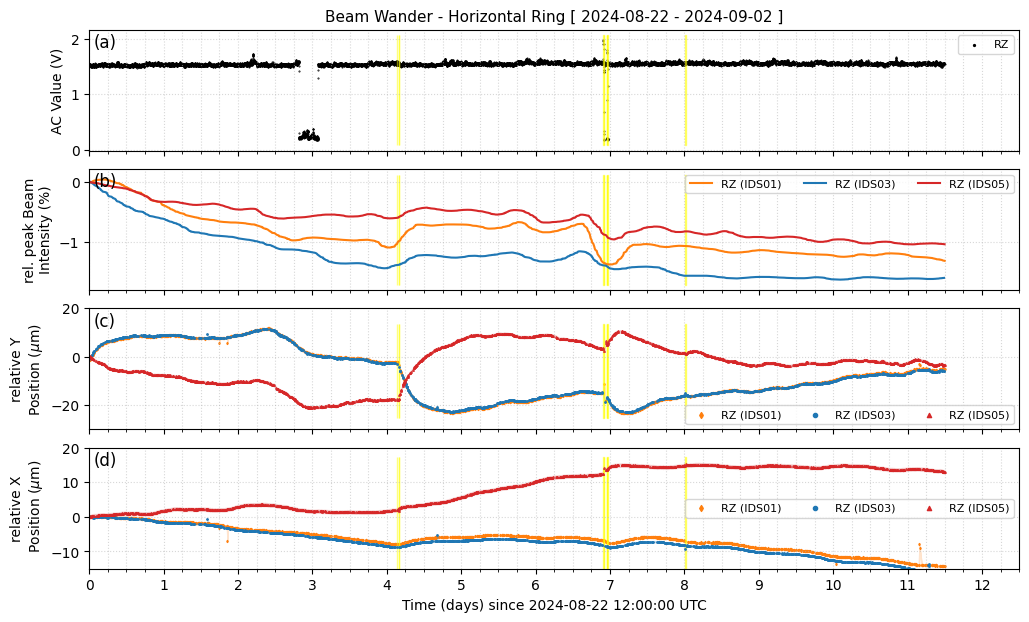

In [18]:
def __makeplot_beam_wander(dfs):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    # reftime = UTCDateTime(dfs[0].time.iloc[0])
    reftime = UTCDateTime(config['t1'])

    time_scaling = 1/86400

    sigma_scaling = 1/2

    Ncol, Nrow = 1, 4

    font = 10

    fig = plt.figure(figsize=(12, 7))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3, :])

    plt.subplots_adjust(hspace=0.15)

    ax0.scatter((beatZ.times_utc - reftime)*time_scaling, beatZ.ac_z, s=0.2, color="k", label="RZ")

    # a00 = ax0.twinx()
    # a00.scatter(beatZ.times_utc - reftime, beatZ.dc_z, s=0.5, color="k")


    for i, df0 in enumerate(dfs):

        times_sec = df0.time_sec*time_scaling

        if i == 0:
            # ax1.scatter(times_sec, __reduce(df0.amp/255*100, 20),
            #             c="tab:orange", s=1, zorder=2, label="RZ (IDS01)", marker="d")
            ax1.plot(times_sec, __reduce(__smooth(df0.amp/255*100, 100), 5),
                        c="tab:orange", zorder=2, label="RZ (IDS01)")

            ax2.scatter(times_sec, df0.y_um_rel, c="tab:orange", s=1, zorder=1, label="RZ (IDS01)", marker="d")
            ax3.scatter(times_sec, df0.x_um_rel, c="tab:orange", s=1, zorder=1, label="RZ (IDS01)", marker="d")
            ax2.fill_between(times_sec,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:orange", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(times_sec,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:orange", alpha=0.2, interpolate=False
                            )
        elif i == 1:

            # ax1.scatter(times_sec, __reduce(df0.amp/255*100, 20),
            #             c="tab:blue", s=1, zorder=2, label="RZ (IDS03)")
            ax1.plot(times_sec, __reduce(__smooth(df0.amp/255*100, 100), 5),
                        c="tab:blue", zorder=2, label="RZ (IDS03)")

            ax2.scatter(times_sec, df0.y_um_rel, c="tab:blue", s=1, zorder=2, label="RZ (IDS03)")
            ax3.scatter(times_sec, df0.x_um_rel, c="tab:blue", s=1, zorder=2, label="RZ (IDS03)")
            ax2.fill_between(times_sec,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:blue", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(times_sec,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:blue", alpha=0.2, interpolate=False
                             )
        elif i == 2:

            # ax1.scatter(times_sec, __reduce(df0.amp/255*100, 20),
            #             c="tab:red", s=1, zorder=2, label="RZ (IDS05)", marker="^")
            ax1.plot(times_sec, __reduce(__smooth(df0.amp/255*100, 100), 5),
                        c="tab:red", zorder=2, label="RZ (IDS05)")

            ax2.scatter(times_sec, df0.y_um_rel, c="tab:red", s=1, zorder=2, label="RZ (IDS05)", marker="^")
            ax3.scatter(times_sec, df0.x_um_rel, c="tab:red", s=1, zorder=2, label="RZ (IDS05)", marker="^")
            ax2.fill_between(times_sec,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:red", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(times_sec,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:red", alpha=0.2, interpolate=False
                             )

    ax0.set_ylabel("AC Value (V)", fontsize=font)
    ax1.set_ylabel("rel. peak Beam\nIntensity (%)", fontsize=font)
    ax2.set_ylabel("relative Y\nPosition ($\mu$m)", fontsize=font)
    ax3.set_ylabel("relative X\n Position ($\mu$m)", fontsize=font)
    ax3.set_xlabel(f"Time (days) since {str(reftime)[:10]} {str(reftime)[11:19]} UTC", fontsize=font)

    # ax1.yaxis.set_minor_locator(MultipleLocator(10))
    # ax2.yaxis.set_minor_locator(MultipleLocator(12.5))
    # ax3.yaxis.set_minor_locator(MultipleLocator(10))

    for ax in [ax0, ax1, ax2, ax3]:
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(.25))

    for _k, (ax, ll) in enumerate(zip([ax0, ax1, ax2, ax3], ['(a)', '(b)', '(c)', '(d)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

        ax.set_xlim(0, (config['t2']-config['t1'])*time_scaling)

        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(reftime)
            lx2_sec = lx2-UTCDateTime(reftime)
            ax.fill_betweenx([_ymin, _ymax],
                             lx1_sec*time_scaling,
                             lx2_sec*time_scaling,
                             color="yellow", alpha=0.5)

    for ax in [ax0, ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")

    for ax in [ax0, ax1, ax2]:
        ax.set_xticklabels([])

    ax0.legend(loc=1, ncol=3, fontsize=font-2, markerscale=3)
    ax1.legend(loc=1, ncol=3, fontsize=font-2, markerscale=3)
    ax2.legend(loc=4, ncol=3, fontsize=font-2, markerscale=3)
    ax3.legend(loc=7, ncol=3, fontsize=font-2, markerscale=3)

    # ax0.set_ylim(1.0, 1.2)
    # ax1.set_ylim(-5, 5)
    ax2.set_ylim(-30, 20)
    ax3.set_ylim(-15, 20)

    # add title
    ax0.set_title(f"Beam Wander - Horizontal Ring [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

fig = __makeplot_beam_wander([df01, df03, df05])

fig.savefig(config['path_to_figures']+f"BeamWander_RZ_01_03_05_{config['date1']}_{config['date2']}_AC.png",
            format="png", dpi=150, bbox_inches='tight')


In [19]:
def __makeplot_beam_wander(dfs):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    time_scaling = 1/86400

    colors = ["tab:blue", "tab:orange"]

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    for i, df0 in enumerate(dfs):
        if i == 0:
            cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2, marker="d")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:orange", s=5, zorder=2)
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:orange", s=5, zorder=2)
        elif i == 1:
            cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2, marker=".")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:blue", s=5, zorder=2)
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:blue", s=5, zorder=2)

#         cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
#         ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
#         ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("Y ($\mu$m)")
    ax1.set_xlabel("X ($\mu$m)")

    ax2.set_ylabel("Y ($\mu$m)")
    # ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("X ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df0.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    x1, x2 = -10, 120
    y1, y2 = -10, 70

    # ax1.set_xlim(x1, x2)
    # ax1.set_ylim(y1, y2)
    # ax2.set_ylim(y1, y2)
    # ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander - Horizontal Ring (S) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.05, 0.85, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)


    plt.show();
    return fig

# fig = __makeplot_beam_wander([df01, df03])

# fig.savefig(config['path_to_figures']+f"BeamWander_RZ_01_and_03_{config['date1']}_{config['date2']}.png",
#             format="png", dpi=150, bbox_inches='tight')


In [20]:
def __makeplot_beam_wander(dfs):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.reduce import __reduce

    time_scaling = 1/86400

    sigma_scaling = 1/2

    Ncol, Nrow = 1, 3

    font = 12

    fig = plt.figure(figsize=(10, 7))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])

    plt.subplots_adjust(hspace=0.05)

    for i, df0 in enumerate(dfs):
        if i == 0:

            ax1.scatter(df0.time_sec*time_scaling, __reduce(df0.amp/255*100, 20),
                        c="tab:orange", s=1, zorder=2, label="RZ (01)", marker="d")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:orange", s=1, zorder=1, label="RZ (01)", marker="d")
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:orange", s=1, zorder=1, label="RZ (01)", marker="d")
            ax2.fill_between(df0.time_sec*time_scaling,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:orange", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(df0.time_sec*time_scaling,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:orange", alpha=0.2, interpolate=False
                            )
        elif i == 1:

            ax1.scatter(df0.time_sec*time_scaling, __reduce(df0.amp/255*100, 20),
                        c="tab:blue", s=1, zorder=2, label="RZ (03)")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:blue", s=1, zorder=2, label="RZ (03)")
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:blue", s=1, zorder=2, label="RZ (03)")
            ax2.fill_between(df0.time_sec*time_scaling,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:blue", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(df0.time_sec*time_scaling,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:blue", alpha=0.2, interpolate=False
                             )
        elif i == 2:

            ax1.scatter(df0.time_sec*time_scaling, __reduce(df0.amp/255*100, 20),
                        c="tab:red", s=1, zorder=2, label="RZ (05)")
            ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c="tab:red", s=1, zorder=2, label="RZ (05)")
            ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c="tab:red", s=1, zorder=2, label="RZ (05)")
            ax2.fill_between(df0.time_sec*time_scaling,
                             df0.y_um_rel-abs(df0.y_um_var)*sigma_scaling,
                             df0.y_um_rel+abs(df0.y_um_var)*sigma_scaling,
                             color="tab:red", alpha=0.2, interpolate=False
                            )
            ax3.fill_between(df0.time_sec*time_scaling,
                             df0.x_um_rel-abs(df0.x_um_var)*sigma_scaling,
                             df0.x_um_rel+abs(df0.x_um_var)*sigma_scaling,
                             color="tab:red", alpha=0.2, interpolate=False
                             )

    ax1.set_ylabel("rel. max. Intensity (%)")
    ax2.set_ylabel("rel. Y Position ($\mu$m)")
    ax3.set_ylabel("rel. X Position($\mu$m)")
    # ax3.set_xlabel(f"Time (days) from {str(df0.time_utc.iloc[0])[:10]} {str(df0.time_utc.iloc[0])[11:19]} UTC")
    ax3.set_xlabel(f"Time (days) from {str(df0.time_utc.iloc[0])[:10]}")


    for _k, (ax, ll) in enumerate(zip([ax1, ax2, ax3], ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)
        ax.legend(loc=9, ncol=3)

    ax1.set_ylim(-45, 5)
    ax2.set_ylim(-50, 50)
    ax3.set_ylim(-50, 50)

    # add title
    ax1.set_title(f"Beam Wander - Horizontal Ring (S) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    plt.show();
    return fig

# fig = __makeplot_beam_wander([df01, df03, df05])

# fig.savefig(config['path_to_figures']+f"BeamWander_RZ_01_03_05_{config['date1']}_{config['date2']}_2.png",
#             format="png", dpi=150, bbox_inches='tight')


In [21]:
opath = data_path+"manuscripts/manuscript_romy_drifts/data/"

df01.to_pickle(opath+"ids01_fsr.pkl")
df03.to_pickle(opath+"ids03_fsr.pkl")
df05.to_pickle(opath+"ids05_fsr.pkl")
